In [ ]:
# Imports & Setup
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay,
                             classification_report)
import joblib

print("✅ Libraries loaded.")

✅ Libraries loaded.


In [ ]:
# Load Dataset
url = "https://raw.githubusercontent.com/tisage/CSIC550/main/data/Lab_03/heart.csv"
df = pd.read_csv(url)

print("✅ Dataset loaded — shape:", df.shape)
df.head()

✅ Dataset loaded — shape: (303, 14)


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,heart_attack
0,42,0,2,120,209,0,1,173,0,0.0,1,0,2,Yes
1,42,1,0,140,226,0,1,178,0,0.0,2,0,2,Yes
2,54,1,0,124,266,0,0,109,1,2.2,1,1,3,No
3,49,1,2,118,149,0,0,126,0,0.8,2,3,2,No
4,67,1,2,152,212,0,0,150,0,0.8,1,0,3,No


In [ ]:
# Inspect Data
df.info()
print("\nMissing values:\n", df.isnull().sum())
print("\nTarget value counts:")
print(df['heart_attack'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           303 non-null    int64  
 1   sex           303 non-null    int64  
 2   cp            303 non-null    int64  
 3   trtbps        303 non-null    int64  
 4   chol          303 non-null    int64  
 5   fbs           303 non-null    int64  
 6   restecg       303 non-null    int64  
 7   thalachh      303 non-null    int64  
 8   exng          303 non-null    int64  
 9   oldpeak       303 non-null    float64
 10  slp           303 non-null    int64  
 11  caa           303 non-null    int64  
 12  thall         303 non-null    int64  
 13  heart_attack  303 non-null    object 
dtypes: float64(1), int64(12), object(1)
memory usage: 33.3+ KB

Missing values:
 age             0
sex             0
cp              0
trtbps          0
chol            0
fbs             0
restecg         0

In [ ]:
# Convert Target to Binary
df['target'] = df['heart_attack'].map({'Yes':1, 'No':0})
df.drop(columns=['heart_attack'], inplace=True)

df['target'].value_counts()

,count
target,
1,165
0,138


In [ ]:
# Identify Feature Types
cat_cols = ['sex', 'exng', 'caa', 'cp', 'fbs', 'restecg', 'slp', 'thall']
con_cols = [c for c in df.columns if c not in cat_cols + ['target']]

cat_cols = [c for c in cat_cols if c in df.columns]
con_cols = [c for c in con_cols if c in df.columns]

print("Categorical:", cat_cols)
print("Continuous:", con_cols)

Categorical: ['sex', 'exng', 'caa', 'cp', 'fbs', 'restecg', 'slp', 'thall']
Continuous: ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']


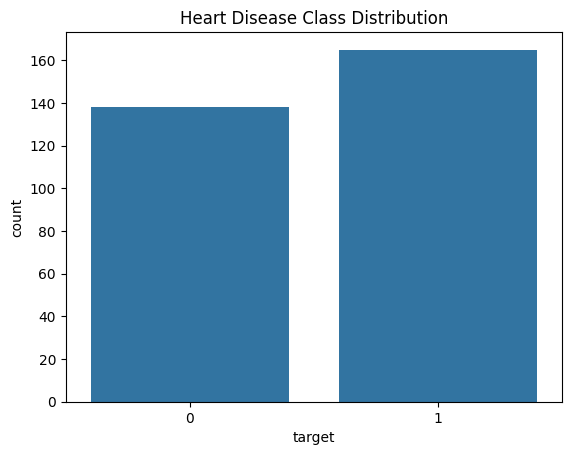

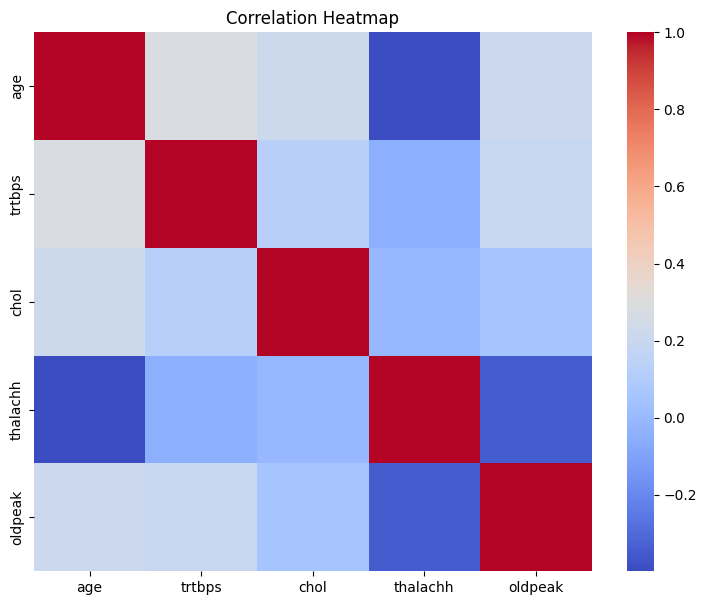

In [ ]:
# EDA (Visuals)
sns.countplot(x='target', data=df)
plt.title("Heart Disease Class Distribution")
plt.show()

if len(con_cols) > 1:
    plt.figure(figsize=(9,7))
    sns.heatmap(df[con_cols].corr(), annot=False, cmap='coolwarm')
    plt.title("Correlation Heatmap")
    plt.show()

In [ ]:
# One-Hot Encoding
df_proc = pd.get_dummies(df, columns=cat_cols, drop_first=True)

X = df_proc.drop(columns=['target'])
y = df_proc['target']

print("✅ After encoding — X shape:", X.shape)

✅ After encoding — X shape: (303, 22)


In [ ]:
# Train/Test Split & Scaling
RSEED = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RSEED, stratify=y)

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

cols_to_scale = [c for c in con_cols if c in X.columns]
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

print("✅ Scaling complete — columns scaled:", cols_to_scale)

✅ Scaling complete — columns scaled: ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']


In [ ]:
# Train Models
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RSEED)
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=RSEED, n_jobs=-1)
svc = make_pipeline(StandardScaler(), LinearSVC(random_state=RSEED, max_iter=10000))

models = {'LogisticRegression': lr, 'RandomForest': rf, 'LinearSVC': svc}

trained = {}
t_train = {}

for name, model in models.items():
    start = time()
    if name == 'LinearSVC':
        model.fit(X_train, y_train)
    else:
        model.fit(X_train_scaled, y_train)
    trained[name] = model
    t_train[name] = time() - start
    print(f"✅ Trained {name} in {t_train[name]:.2f}s")

✅ Trained LogisticRegression in 0.03s
✅ Trained RandomForest in 0.26s
✅ Trained LinearSVC in 0.01s


In [ ]:
# Evaluate Models
def evaluate(model, name):
    if name == "LinearSVC":
        y_pred = model.predict(X_test)
        y_score = model.decision_function(X_test)
    else:
        y_pred = model.predict(X_test_scaled)
        y_score = model.predict_proba(X_test_scaled)[:,1]

    return {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "auc": roc_auc_score(y_test, y_score),
        "pred": y_pred,
        "score": y_score
    }

results = {name: evaluate(model, name) for name, model in trained.items()}
results

{'LogisticRegression': {'accuracy': 0.819672131147541,
  'precision': 0.8235294117647058,
  'recall': 0.8484848484848485,
  'f1': 0.835820895522388,
  'auc': np.float64(0.8712121212121212),
  'pred': array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
         0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]),
  'score': array([0.00812281, 0.25822991, 0.32636933, 0.17108389, 0.2822162 ,
         0.28247033, 0.72424396, 0.36186498, 0.48166836, 0.06170387,
         0.7292668 , 0.89626803, 0.00865247, 0.89041552, 0.84001485,
         0.69732928, 0.94695305, 0.58605328, 0.79622149, 0.98806169,
         0.56280756, 0.75511632, 0.99006712, 0.14545779, 0.5677654 ,
         0.37122141, 0.04475151, 0.21555262, 0.02645874, 0.66911578,
         0.16150838, 0.30241807, 0.96531045, 0.00559901, 0.03621332,
         0.94805129, 0.35917722, 0.03890428, 0.98550719, 0.62391898,
         0.39800556, 0.967087

🏆 Best model by F1: LogisticRegression


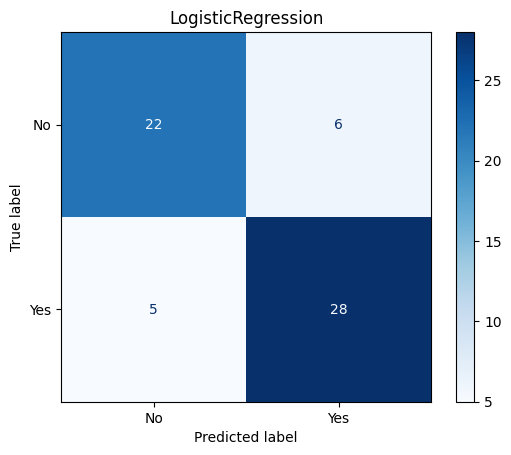

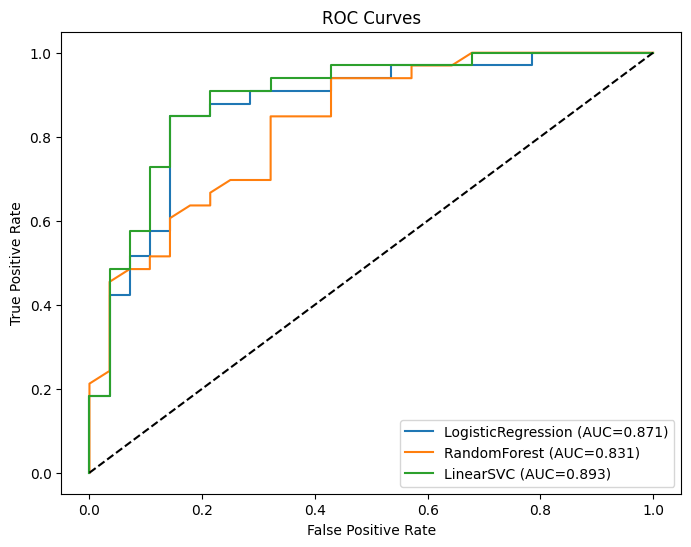

In [ ]:
# Confusion Matrix + ROC Curve
best = max(results.keys(), key=lambda m: results[m]["f1"])
print("🏆 Best model by F1:", best)

cm = confusion_matrix(y_test, results[best]["pred"])
ConfusionMatrixDisplay(cm, display_labels=["No", "Yes"]).plot(cmap="Blues")
plt.title(best)
plt.show()

plt.figure(figsize=(8,6))
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res["score"])
    plt.plot(fpr, tpr, label=f"{name} (AUC={res['auc']:.3f})")

plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.show()

In [ ]:
# Random Forest Hyperparameter Tuning
param_dist = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 5, 10, 20],
    "max_features": ["sqrt", "log2", None]
}

search = RandomizedSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=RSEED, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=6,
    scoring="recall",
    cv=3,
    n_jobs=-1,
    random_state=RSEED,
)

search.fit(X_train_scaled, y_train)

print("✅ Best Parameters:", search.best_params_)

best_rf = search.best_estimator_

y_pred = best_rf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

✅ Best Parameters: {'n_estimators': 200, 'max_features': None, 'max_depth': 20}
              precision    recall  f1-score   support

           0       0.64      0.64      0.64        28
           1       0.70      0.70      0.70        33

    accuracy                           0.67        61
   macro avg       0.67      0.67      0.67        61
weighted avg       0.67      0.67      0.67        61

